# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Deep Learning Frameworks</font>

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


## Lab - Função Softmax e Classificação Multiclasse com MXNet

O objetivo deste Lab é mostrar como implementar a Função Softmax com o Framework MXNet e discutir suas características. A Função Softmax é amplamente usada em Deep Learning, especialmente em tarefas de Classificação Multiclasse, quando mais de duas classes devem ser previstas pelo modelo.

A Função Softmax transforma a saída da rede neural (um valor para cada classe) em probabilidades e então geramos uma única previsão de classe, normalmente usando a função argmax(). Isso será demonstrado ao final do Lab.

Todas as células estão comentadas. Leia cada comentário com atenção, execute o Jupyter Notebook e faça modificações para compreender o funcionamento da Função Softmax.

![title](imagens/softmax.png)

Use o Deep Learning Book como referência:
    
http://www.deeplearningbook.com.br/

In [2]:
!nvidia-smi

Wed May 20 17:20:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 00000000:05:00.0 Off |                  N/A |
| 23%   38C    P8     8W / 250W |    254MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:09:00.0 Off |                  N/A |
| 23%   35C    P8     9W / 250W |    149MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [4]:
# Instala o pacote MXNet com suporte a GPU
!pip install -q mxnet-cu102

In [5]:
# Imports
import mxnet as mx
import matplotlib
import matplotlib.pyplot as plt
from mxnet import nd, autograd, gluon

In [6]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

matplotlib 3.2.1
mxnet      1.6.0
Data Science Academy


In [7]:
# Dados serão processados pela CPU e o modelo pela GPU. Altere o código abaixo se quiser executar apenas na CPU
data_ctx = mx.cpu()
model_ctx = mx.gpu()

### Carregando o Dataset

Usaremos para este Lab o dataset MNIST com dígitos escritos à mão. O dataset tem 10 classes de saída, dígitos de 0 a 9. Vamos treinar um modelo de rede neural artificial e usar a função softmax para as previsões.

In [8]:
# Função para transformação dos dados. O que fazemos aqui é colocar os dados na mesma escala.
def transform(data, label):
    return data.astype('float32')/255.0, label.astype('float32')

In [9]:
# Extraímos os dados de treino
mnist_treino = gluon.data.vision.MNIST(train = True, transform = transform)

In [10]:
# Extraímos os dados de teste
mnist_teste = gluon.data.vision.MNIST(train = False, transform = transform)

In [11]:
# Obtemos um elemento do dataset de treino (no índice 0)
image, label = mnist_treino[0]

In [12]:
# Shape da imagem (3 dimensões, sendo altura, largura e canais de cores)
image.shape

(28, 28, 1)

In [13]:
# Shape do label (vazio indica valor escalar, em nosso caso valores entre 0 e 9)
label.shape

()

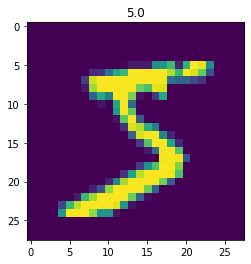

In [14]:
# Plot da imagem e label
plt.imshow(image.reshape((28, 28)).asnumpy())
plt.title(label)
plt.show()

### Definindo o DataLoader

O DataLoader extrai batches de dados para alimentar o modelo durante o treinamento.

In [15]:
# Tamanho do batch
batch_size = 64

In [16]:
# Batches de treinamento
dados_treino = gluon.data.DataLoader(mnist_treino, batch_size = batch_size, shuffle = True)

In [17]:
# Batches de teste
dados_teste = gluon.data.DataLoader(mnist_teste, batch_size = batch_size, shuffle = False)

### Construindo o Modelo

Agora construímos o modelo de rede neural para classificação multiclasse.

In [18]:
# Criamos uma camada densa com 10 neurônios
modelo = gluon.nn.Dense(10)

In [19]:
# Iniciamos o modelo e os pesos
modelo.initialize(mx.init.Normal(sigma = 1.0), model_ctx)

In [20]:
# Precisamos de uma função de custo e o MXNet oferece a SoftmaxCrossEntropyLoss que calcula o erro do modelo,
# depois de fazer as previsões com a função softmax
categoricalcrossentropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [21]:
# Com o erro calculado, precisamos otimizar o modelo, ajustando os valores dos pesos
# Usamos o algoritmo SGD - Stochastic Gradient Descent
optimizer = gluon.Trainer(modelo.collect_params(), 'sgd', {'learning_rate': 0.1})

In [22]:
# Por fim, vamos criar uma função para calcular a acurácia do modelo
# A função argmax() obtem a maior probabilidade, ou seja, o modelo vai fazer 10 previsões, uma para cada classe
# A maior probabilidade, será a previsão final do modelo
def accuracy(predictions, labels):
    return nd.mean(predictions.argmax(1) == labels)

### Treinamento do Modelo

Agora treinamos o modelo.

In [23]:
# Hiperparâmetros
epochs = 20
num_batches = 60000/batch_size
losses = []
accs = []

In [24]:
# Loop de treinamento
print("\nIniciando o treinamento do modelo...\n")
for epoch in range(epochs):
    
    # Inicializa o erro acumulado
    cumulative_loss = 0
    
    # Inicializa a acurácia acumlada
    cumulative_acc = 0
    
    # Loop pelos bacthes de dados de treino
    for features, labels in dados_treino:
        
        # Extrai os atributos (variáveis preditoras)
        features = features.as_in_context(model_ctx)
        
        # Extrai os labels (variáveis de saída)
        labels = labels.as_in_context(model_ctx)
        
        # Faz as previsões e calcula o erro do modelo
        with autograd.record():
            output = modelo(features)
            loss = categoricalcrossentropy(output, labels)
            
        # Inicia o backpropagation
        loss.backward()
        
        # Otimiza o modelo atualizando os pesos para a próxima passada
        optimizer.step(batch_size)
        
        # Calcula erro e acurácia
        cumulative_loss += loss.mean()
        cumulative_acc += accuracy(output, labels)
        
    # Custo e acurácia da época    
    cost = cumulative_loss.asscalar()/num_batches
    acc = cumulative_acc.asscalar()/num_batches
    
    # Print
    print(f'Epoch: {epoch} Erro: {cost} Acurácia: {acc}')
    losses.append(cost)
    accs.append(acc)
    
print("\nTreinamento concluído.\n")


Iniciando o treinamento do modelo...

Epoch: 0 Erro: 1.955133984375 Acurácia: 0.67355
Epoch: 1 Erro: 0.8580482421875 Acurácia: 0.8218166666666666
Epoch: 2 Erro: 0.7077859375 Acurácia: 0.847
Epoch: 3 Erro: 0.6288337890625 Acurácia: 0.8614666666666667
Epoch: 4 Erro: 0.5785268229166667 Acurácia: 0.869
Epoch: 5 Erro: 0.54241474609375 Acurácia: 0.8754
Epoch: 6 Erro: 0.5143861979166666 Acurácia: 0.8804833333333333
Epoch: 7 Erro: 0.49206930338541666 Acurácia: 0.8840166666666667
Epoch: 8 Erro: 0.47354150390625 Acurácia: 0.8877833333333334
Epoch: 9 Erro: 0.45733896484375 Acurácia: 0.8905166666666666
Epoch: 10 Erro: 0.4430499674479167 Acurácia: 0.8929333333333334
Epoch: 11 Erro: 0.4308859049479167 Acurácia: 0.8947166666666667
Epoch: 12 Erro: 0.4200426432291667 Acurácia: 0.8963833333333333
Epoch: 13 Erro: 0.41077685546875 Acurácia: 0.89835
Epoch: 14 Erro: 0.4023052408854167 Acurácia: 0.90085
Epoch: 15 Erro: 0.39443125 Acurácia: 0.9016666666666666
Epoch: 16 Erro: 0.3873283203125 Acurácia: 0.9026


### Testando o Modelo

Agora testamos o modelo.

In [25]:
# Iniciamos variáveis para o cálculo da acurácia e número de bacthes
acc = 0.0
batches = 0

In [26]:
# Loop pelos dados de treino para fazer as previsões e calcular a acurácia total
for features, labels in dados_teste:
    features = features.as_in_context(model_ctx).reshape((-1, 784))
    labels = labels.as_in_context(model_ctx)
    predictions = modelo(features)
    acc += accuracy(predictions, labels)
    batches += 1

In [27]:
print(f'Acurácia em Teste: {acc.asscalar()/batches}')

Acurácia em Teste: 0.90734474522293


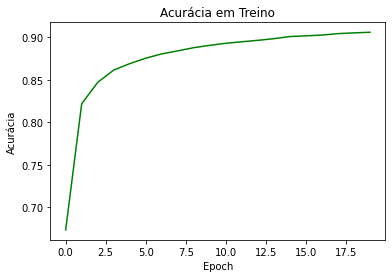

In [28]:
# Plot da Acurácia em Treino
plt.plot(accs, 'g')
plt.title('Acurácia em Treino')
plt.xlabel('Epoch')
plt.ylabel('Acurácia')
plt.show()

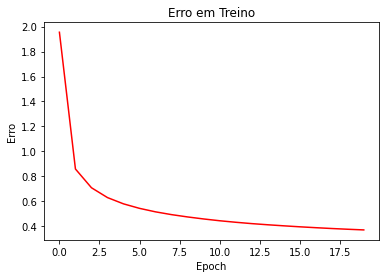

In [29]:
# Plot do Erro em Treino
plt.plot(losses, 'r')
plt.title('Erro em Treino')
plt.xlabel('Epoch')
plt.ylabel('Erro')
plt.show()

Previsões da Rede Neural (a função softmax vai obter o maior valor): 
[[  6.0835724  -8.041874    9.8963175  10.872908    2.2937663   6.1577325
  -12.294527   21.616291    6.5760684  11.909309 ]]
<NDArray 1x10 @gpu(0)>


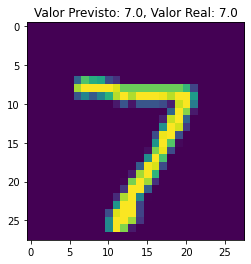

Previsões da Rede Neural (a função softmax vai obter o maior valor): 
[[  6.9824734  -2.3900738  16.122814    9.147577  -20.354061   12.266544
    9.213014  -26.79968    11.016783  -18.08144  ]]
<NDArray 1x10 @gpu(0)>


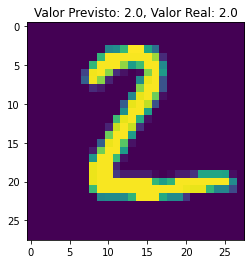

Previsões da Rede Neural (a função softmax vai obter o maior valor): 
[[-11.174872     9.1477165    4.452926     1.3678877   -1.8387046
    0.6708195    0.15556985   1.774803     1.2126713   -0.40231234]]
<NDArray 1x10 @gpu(0)>


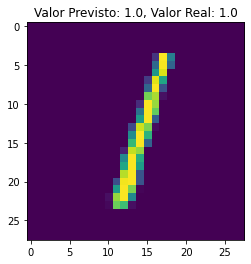

Previsões da Rede Neural (a função softmax vai obter o maior valor): 
[[ 14.597072   -18.480667     2.1604428   -3.2077367  -12.445295
   -0.94546485   0.5051214   -4.330636    -1.625145    -2.1121502 ]]
<NDArray 1x10 @gpu(0)>


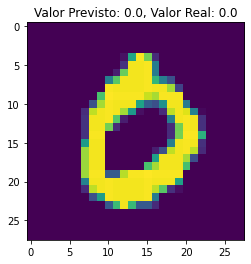

Previsões da Rede Neural (a função softmax vai obter o maior valor): 
[[ -6.192108  -12.900526    1.3319671  -8.256805   10.48709    -4.089473
    1.885591    1.7557448   2.555035    5.1508865]]
<NDArray 1x10 @gpu(0)>


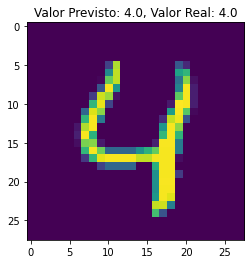

Previsões da Rede Neural (a função softmax vai obter o maior valor): 
[[-14.200579    11.532734     3.236494     3.1523988   -2.8473103
   -1.3728845   -4.3530927    4.934839     4.889869     0.93483216]]
<NDArray 1x10 @gpu(0)>


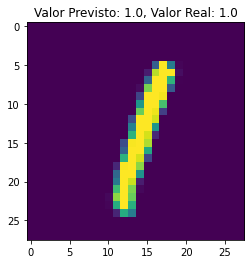

In [30]:
# Previsões com o modelo treinado
samples = 5
for i, batch in enumerate(mnist_teste):
    features = batch[0].as_in_context(model_ctx).reshape((1, 784))
    labels = batch[1]
    probs = modelo(features)
    print("Previsões da Rede Neural (a função softmax vai obter o maior valor):", probs)
    predictions = modelo(features).argmax(1).asscalar()
    plt.imshow(features.reshape((28, 28)).asnumpy())
    plt.title(f'Valor Previsto: {predictions}, Valor Real: {labels}')
    plt.show()
    if i == samples:
        break

Se você verificar acima, a função argmax() sempre retorna o maior valor de cada vetor de previsões, o que se torna a previsão final de classe.

# Fim